#### **Computing normative models of diffusion metrics for each bundle**

In [2]:
# Imports
import os

import matplotlib.pyplot as plt
from matplotlib import font_manager
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
# Set root Dir for the project.
ROOT_DIR = "/Users/anthonygagnon/Documents/École/Université/Projects/nf-pediatric/"
RESULTS_DIR = ROOT_DIR + "NormativeModels/"
REPOSITORY = "/Users/anthonygagnon/code/nf-pediatric-paper/"

# Dataset folder
PING_DATA = ROOT_DIR + "/PING/"
BCP_DATA = ROOT_DIR + "/BCP/"
BANDA_DATA = ROOT_DIR + "/BANDA/"
GESTE_DATA = ROOT_DIR + "/GESTE/"
ABCD_DATA = ROOT_DIR + "/ABCD/"
MYRNA_DATA = ROOT_DIR + "/MYRNA/"

# Create a directory for the results if it doesn't exist
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)

In [4]:
# Fetch Harding font.
font_files = []
for fontpath in font_manager.findSystemFonts(fontpaths=None, fontext='ttf'):
    if "Harding".lower() in fontpath.lower():
        font_files.append(fontpath)
for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

# Set Harding font.
plt.rcParams['font.family'] = 'Harding Text Web'

# Set the Set2 color palette as an iterable.
cmap = sns.color_palette("Set2", 8)

In [7]:
# Load the data for each cohort.
ping_df = pd.read_csv(PING_DATA + "bundles_mean_stats.tsv", sep="\t")
ping_df.rename(columns={"sample": "subject_id", "session": "session_id"}, inplace=True)
bcp_df = pd.read_csv(BCP_DATA + "withPriors/bundles_mean_stats.tsv", sep="\t")
bcp_df.rename(columns={"sample": "subject_id", "session": "session_id"}, inplace=True)
banda_df = pd.read_csv(BANDA_DATA + "bundles_mean_stats.tsv", sep="\t")
banda_df.rename(columns={"sample": "subject_id", "session": "session_id"}, inplace=True)
geste_df = pd.read_csv(GESTE_DATA + "bundles_mean_stats.tsv", sep="\t")
geste_df.rename(columns={"sample": "subject_id", "session": "session_id"}, inplace=True)
abcd_df = pd.read_csv(ABCD_DATA + "bundles_mean_stats.tsv", sep="\t")
abcd_df.rename(columns={"sample": "subject_id", "session": "session_id"}, inplace=True)
myrna_df = pd.read_csv(MYRNA_DATA + "bundles_mean_stats.tsv", sep="\t")
myrna_df.rename(columns={"sample": "subject_id", "session": "session_id"}, inplace=True)

# Load up the demographics data we need. 
demo_df = pd.read_csv(ROOT_DIR + "Priors/All_Priors.csv")

# Function that will fetch corresponding demo data for each subject/session in a row.
def fetch_demo_data(row, demo_df):
    subject_id = row['subject_id']
    session_id = row['session_id']
    if isinstance(session_id, str) or not np.isnan(session_id):
        demo_row = demo_df[(demo_df['subject_id'] == subject_id) & (demo_df['session_id'] == session_id)]
    else:
        demo_row = demo_df[(demo_df['subject_id'] == subject_id)]
    if not demo_row.empty:
        return pd.Series({
            'age': demo_row.iloc[0]['age'],
            'sex': demo_row.iloc[0]['sex'],
            'cohort': demo_row.iloc[0]['cohort']
        })
    else:
        return pd.Series({'age': None, 'sex': None, 'cohort': None})

# Use this function to merge demo data into each cohort dataframe.
def merge_with_demo(cohort_df, demo_df):
    demo_data = cohort_df.apply(lambda row: fetch_demo_data(row, demo_df), axis=1)
    merged_df = pd.concat([cohort_df.reset_index(drop=True), demo_data.reset_index(drop=True)], axis=1)
    return merged_df

ping_df = merge_with_demo(ping_df, demo_df)
bcp_df = merge_with_demo(bcp_df, demo_df)
banda_df = merge_with_demo(banda_df, demo_df)
geste_df = merge_with_demo(geste_df, demo_df)
abcd_df = merge_with_demo(abcd_df, demo_df)
myrna_df = merge_with_demo(myrna_df, demo_df)



# Assert that there is no missing values in sex, age, or cohort columns.
for df, name in zip([ping_df, bcp_df, banda_df, geste_df, abcd_df, myrna_df],
                    ['PING', 'BCP', 'BANDA', 'GESTE', 'ABCD', 'MYRNA']):
    # Let's drop any rows with missing demo data for now.
    length_before = len(df)
    df.dropna(subset=['age', 'sex', 'cohort'], inplace=True)
    length_after = len(df)

    print(f"Dropped {length_before - length_after} rows with missing demo data from {name} dataframe")

    assert df['sex'].notnull().all(), f"Missing sex values in {name} dataframe"
    assert df['age'].notnull().all(), f"Missing age values in {name} dataframe"
    assert df['cohort'].notnull().all(), f"Missing cohort values in {name} dataframe"

Dropped 0 rows with missing demo data from PING dataframe
Dropped 5982 rows with missing demo data from BCP dataframe
Dropped 0 rows with missing demo data from BANDA dataframe
Dropped 49 rows with missing demo data from GESTE dataframe
Dropped 0 rows with missing demo data from ABCD dataframe
Dropped 296 rows with missing demo data from MYRNA dataframe


In [8]:
# Do a big sanity check that all dataframes have the same columns
dataframes = [ping_df, bcp_df, banda_df, geste_df, abcd_df, myrna_df]
first_df_columns = set(dataframes[0].columns)
for i, df in enumerate(dataframes[1:], start=1):
    if set(df.columns) != first_df_columns:
        raise ValueError(f"DataFrame at index {i} has different columns.")

# Concatenate all dataframes into a single one.
all_data_df = pd.concat(dataframes, ignore_index=True)

# Now remove outliers based on the 3 IQR rule for each bundle and each metric.
outliers = set()
metrics = ['fa', 'md', 'rd', 'ad', 'afd_fixel']
for bundle in all_data_df['bundle'].unique():
    bundle_df = all_data_df[all_data_df['bundle'] == bundle]
    for metric in metrics:
        median = bundle_df[metric].quantile(0.5)
        iqr = bundle_df[metric].quantile(0.75) - bundle_df[metric].quantile(0.25)
        lower_bound = median - 5 * iqr
        upper_bound = median + 5 * iqr
        bundle_outliers = bundle_df[(bundle_df[metric] < lower_bound) | (bundle_df[metric] > upper_bound)]
        for _, row in bundle_outliers.iterrows():
            outliers.add((row['subject_id'], row['session_id'] if 'session_id' in row else None))

# Print out the outliers found.
print(f"Found {len(outliers)} outliers!")
print("Number of subjects before removing outliers:", len(all_data_df['subject_id'].unique()))

# Remove outliers from the all_data_df dataframe.
for subject_id, session_id in outliers:
    if not (pd.isna(session_id) or session_id == ""):
        all_data_df = all_data_df[~((all_data_df['subject_id'] == subject_id) & (all_data_df['session_id'] == session_id))]
    else:
        all_data_df = all_data_df[all_data_df['subject_id'] != subject_id]

# Print out the number of subjects after removing outliers.
print("Number of subjects after removing outliers:", len(all_data_df['subject_id'].unique()))

all_data_df.to_csv(RESULTS_DIR + "all_cohort_bundles_mean_stats.tsv", sep="\t", index=False)

Found 75 outliers!
Number of subjects before removing outliers: 1513
Number of subjects after removing outliers: 1441


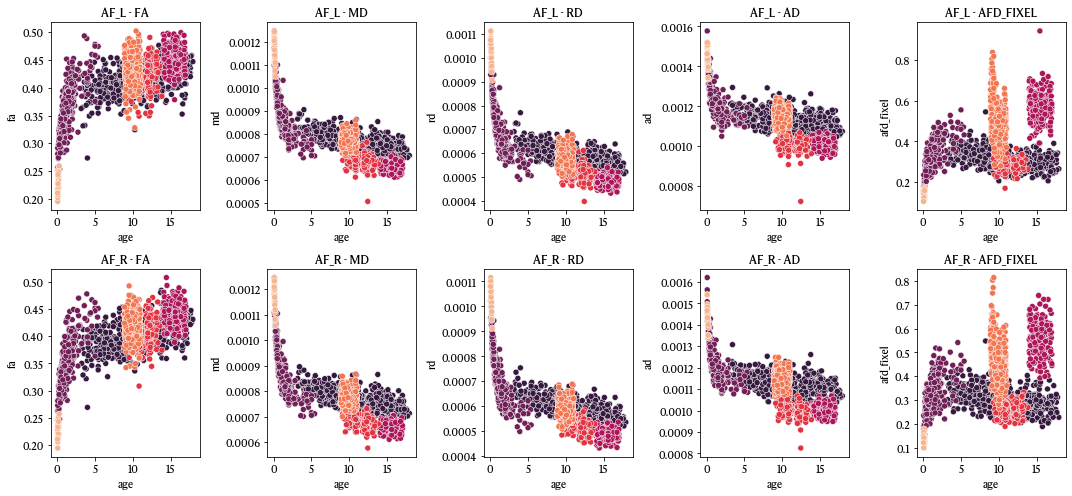

In [9]:
# Let's plot only the PYT_L for FA, MD, RD, AD, and afd_fixel.
fig, axes = plt.subplots(2, 5, figsize=(15, 7))
metrics = ['fa', 'md', 'rd', 'ad', 'afd_fixel']
bundle = ['AF_L', 'AF_R']
for i, metric in enumerate(metrics):
    for j, bndl in enumerate(bundle):
        ax = axes[j, i]
        sns.scatterplot(data=all_data_df[all_data_df['bundle'] == bndl],
                        x='age', y=metric,
                        hue='cohort', ax=ax, palette='rocket', legend=False)
        ax.set_title(f"{bndl} - {metric.upper()}")
plt.tight_layout()
plt.show()

In [ ]:
# Fit GAMLSS models for each metric and bundle using R script.
!python bundleGAMLSS.py \
    "{RESULTS_DIR}/all_cohort_bundles_mean_stats.tsv" \
    "{RESULTS_DIR}/GAMLSS_Models/" \
    --metric fa ad md rd \
    --rscript "{REPOSITORY}/gamlss.R" \
    --bundle AF_L AF_R CC_Fr_1 CC_Fr_2 CC_Oc CC_Pa CC_Pr_Po CC_Te CG_L CG_R FAT_L FAT_R FPT_L FPT_R FX_L FX_R IFOF_L IFOF_R ILF_L ILF_R MdLF_L MdLF_R OR_ML_L OR_ML_R POPT_L POPT_R PYT_L PYT_R SLF_L SLF_R UF_L UF_R\
    --n_cpus 6 \
    -f

/Users/anthonygagnon/code/nf-pediatric-paper/bundleGAMLSS.py:85: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(args.in_dataframe, sep="\t")
Fitting GAMLSS models for each provided bundle: 100%|█| 32/32 [1:03:20<00:00, 11
